In [1]:
import numpy as np
import pickle
import pandas as pd
import os
import sacc
import yaml
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rc('legend',fontsize=18)

In [11]:
class cl_ensemble(object):
    def __init__(self, s, y):

        # Apply scale cuts
        self._apply_scale_cuts(s, y)

        self.indices = np.array([])
        self.data = []
        self.ls = []
        self.pairs = []
        for cl in y["order"]:
            t1, t2 = cl["tracers"]
            cls = cl["cls"]
            for cl_name in cls:
                l, c_ell, ind = s.get_ell_cl(
                    cl_name, t1, t2,
                    return_cov=False,
                    return_ind=True)
                self.indices = np.append(self.indices, ind)
                self.data.append(c_ell)
                self.ls.append(l)
                self.pairs.append([t1, t2])
        
        self.indices = self.indices.astype(int)
        self.cov = s.covariance.dense
        self.cov = np.transpose(np.transpose(self.cov[self.indices])[self.indices])
        lengths = [len(l) for l in self.ls]
        self.edges  = np.append(np.array([0]), np.cumsum(lengths))
        errs = np.sqrt(np.diag(self.cov))
        self.errs = self._segment(errs)

    def _apply_scale_cuts(self, s, y):
        indices = np.array([])
        for cl in y["order"]:
            t1, t2 = cl["tracers"]
            cls = cl["cls"]
            if "ell_cuts" in list(cl.keys()):
                lmin, lmax = cl["ell_cuts"]
                for cl_name in cls:
                    ind = s.indices(cl_name, (t1, t2),
                                    ell__gt=lmin, ell__lt=lmax)
                    indices = np.append(indices, ind)
        if len(indices) != 0:
            s.keep_indices(indices)

    def _segment(self, A):
        seg_A = []
        for i in range(0, len(self.edges)-1):
            seg_A.append(A[self.edges[i]:self.edges[i+1]])
        return seg_A

def plot_cls(cl_ensemble, wanted_pairs, fmts=['ro', 'bo', 'ko']):
    pairs_pos = [self.pairs.index(pair) for pair in wanted_pairs]
    t_i = np.transpose(wanted_pairs)[0]
    t_j = np.transpose(wanted_pairs)[1]
    unique_t_i = np.unique(t_i)
    unique_t_j = np.unique(t_j)
    l_t_i = len(unique_t_i)
    l_t_j = len(unique_t_j)
    npair = 0
    print(wanted_pairs)

    if (t_j == t_i).all():
        figure, axis = plt.subplots(1, l_t_j, figsize=(5*l_t_i, 5*1))
        for i in range(0, l_t_i):
            proposed_pair = [unique_t_i[i], unique_t_j[i]]
            pos = pairs_pos[npair]
            ls = self.ls[pos]
            data = self.data[pos]
            err = self.errs[pos]
            axis[i].errorbar(ls, data, yerr=err, fmt='gs', label='Data')
            axis[i].set_title("{}_{}".format(proposed_pair[0],proposed_pair[1]))
            axis[i].set_xscale("log")
            axis[i].set_yscale("log")
            npair += 1
        plt.legend()
        plt.show()
    else:
        figure, axis = plt.subplots(l_t_i, l_t_j, figsize=(5*l_t_i, 5*l_t_j))
        for i in range(0, l_t_i):
            for j in range(0, l_t_j):
                proposed_pair = [unique_t_i[i], unique_t_j[j]]
                if proposed_pair in wanted_pairs:
                    pos = pairs_pos[npair]
                    ls = self.ls[pos]
                    data = self.data[pos]
                    err = self.errs[pos]
                    axis[i, j].errorbar(ls, data, yerr=err, fmt='gs', label='Data')
                    axis[i, j].set_title("{}_{}".format(proposed_pair[0],proposed_pair[1]))
                    axis[i, j].set_xscale("log")
                    axis[i, j].set_yscale("log")
                    npair += 1
                else:
                    axis[i, j].axis('off')
        plt.legend()
        plt.show()

In [12]:
s = sacc.Sacc.load_fits("/home/jaimerz/Documents/UCL/3x2_analytical/data/HSC/HSC.sacc")
y = yaml.load(open("/home/jaimerz/Documents/UCL/3x2_analytical/data/HSC/HSC.yml"), Loader=yaml.FullLoader)

In [13]:
cle = cl_ensemble(s,y)

In [14]:
cle.errs

[array([9.52513486e-07]),
 array([5.79867854e-07, 2.26221485e-07, 1.10280282e-07, 3.65058402e-08,
        2.01316062e-08, 1.33101128e-08, 5.75607984e-09, 3.62345932e-09,
        2.43794702e-09]),
 array([7.09655389e-07, 2.80245384e-07, 1.34893730e-07]),
 array([4.91887870e-07, 1.97189551e-07, 9.71335864e-08, 3.18927869e-08,
        1.71849722e-08, 1.11391315e-08, 4.74039860e-09, 2.96223980e-09,
        2.00328384e-09]),
 array([4.25070540e-07, 1.72288914e-07, 8.35765656e-08, 2.65687554e-08,
        1.38359182e-08, 8.82820039e-09, 3.74882376e-09, 2.37130179e-09,
        1.63529822e-09]),
 array([5.10636145e-07, 2.12753663e-07, 1.04287913e-07, 3.30730621e-08]),
 array([3.07329055e-07, 1.27834814e-07, 6.47753312e-08, 2.14151581e-08,
        1.16040593e-08, 7.53238738e-09, 3.21831773e-09, 2.03638796e-09,
        1.40682530e-09]),
 array([2.65619970e-07, 1.11722618e-07, 5.57279390e-08, 1.78381276e-08,
        9.34211968e-09, 5.96945066e-09, 2.54488653e-09, 1.63002574e-09,
        1.14838505

In [15]:
errs = np.sqrt(np.diag(cle.cov))
seg_err = []
for i in range(len(cle.edges)-1):
    lower, upper = cle.edges[i], cle.edges[i+1]
    err = errs[lower:upper]
    seg_err.append(err)

In [16]:
seg_err

[array([9.52513486e-07]),
 array([5.79867854e-07, 2.26221485e-07, 1.10280282e-07, 3.65058402e-08,
        2.01316062e-08, 1.33101128e-08, 5.75607984e-09, 3.62345932e-09,
        2.43794702e-09]),
 array([7.09655389e-07, 2.80245384e-07, 1.34893730e-07]),
 array([4.91887870e-07, 1.97189551e-07, 9.71335864e-08, 3.18927869e-08,
        1.71849722e-08, 1.11391315e-08, 4.74039860e-09, 2.96223980e-09,
        2.00328384e-09]),
 array([4.25070540e-07, 1.72288914e-07, 8.35765656e-08, 2.65687554e-08,
        1.38359182e-08, 8.82820039e-09, 3.74882376e-09, 2.37130179e-09,
        1.63529822e-09]),
 array([5.10636145e-07, 2.12753663e-07, 1.04287913e-07, 3.30730621e-08]),
 array([3.07329055e-07, 1.27834814e-07, 6.47753312e-08, 2.14151581e-08,
        1.16040593e-08, 7.53238738e-09, 3.21831773e-09, 2.03638796e-09,
        1.40682530e-09]),
 array([2.65619970e-07, 1.11722618e-07, 5.57279390e-08, 1.78381276e-08,
        9.34211968e-09, 5.96945066e-09, 2.54488653e-09, 1.63002574e-09,
        1.14838505

[['lens_0', 'lens_0'], ['lens_1', 'lens_1'], ['lens_2', 'lens_2'], ['lens_3', 'lens_3']]


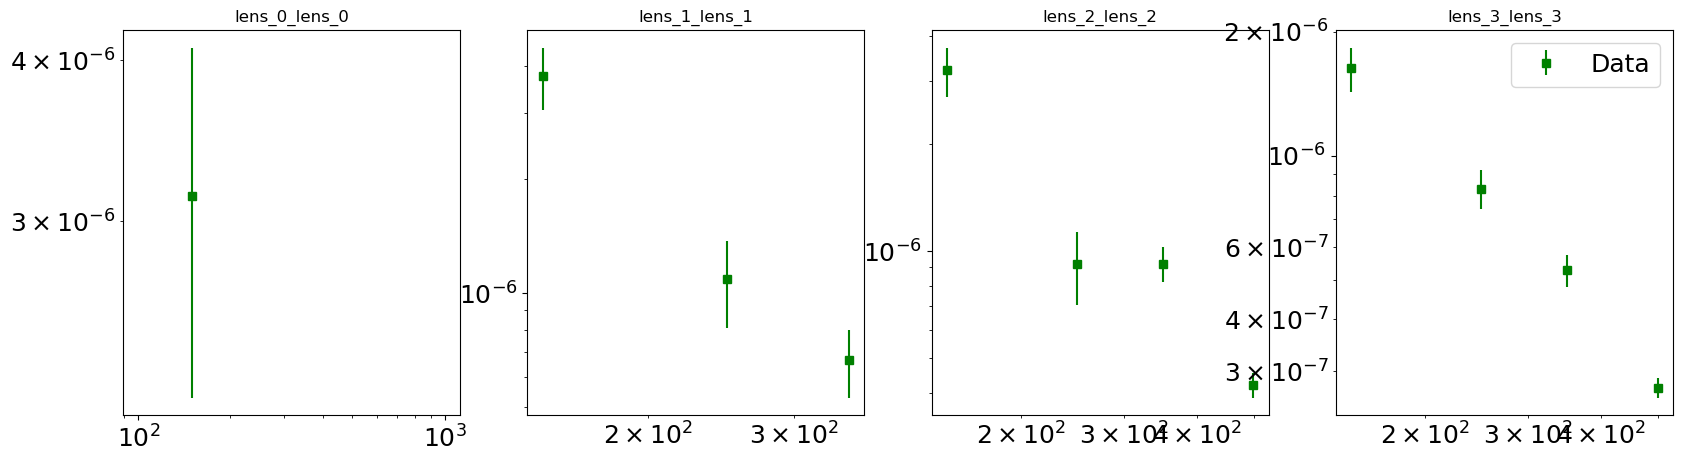

In [17]:
cle.plot_cls([['lens_0', 'lens_0'],
              ['lens_1', 'lens_1'],
              ['lens_2', 'lens_2'], 
              ['lens_3', 'lens_3']])

[['lens_0', 'lens_0'], ['lens_1', 'lens_0'], ['lens_1', 'lens_1'], ['lens_2', 'lens_0'], ['lens_2', 'lens_1'], ['lens_2', 'lens_2'], ['lens_3', 'lens_0'], ['lens_3', 'lens_1'], ['lens_3', 'lens_2'], ['lens_3', 'lens_3']]


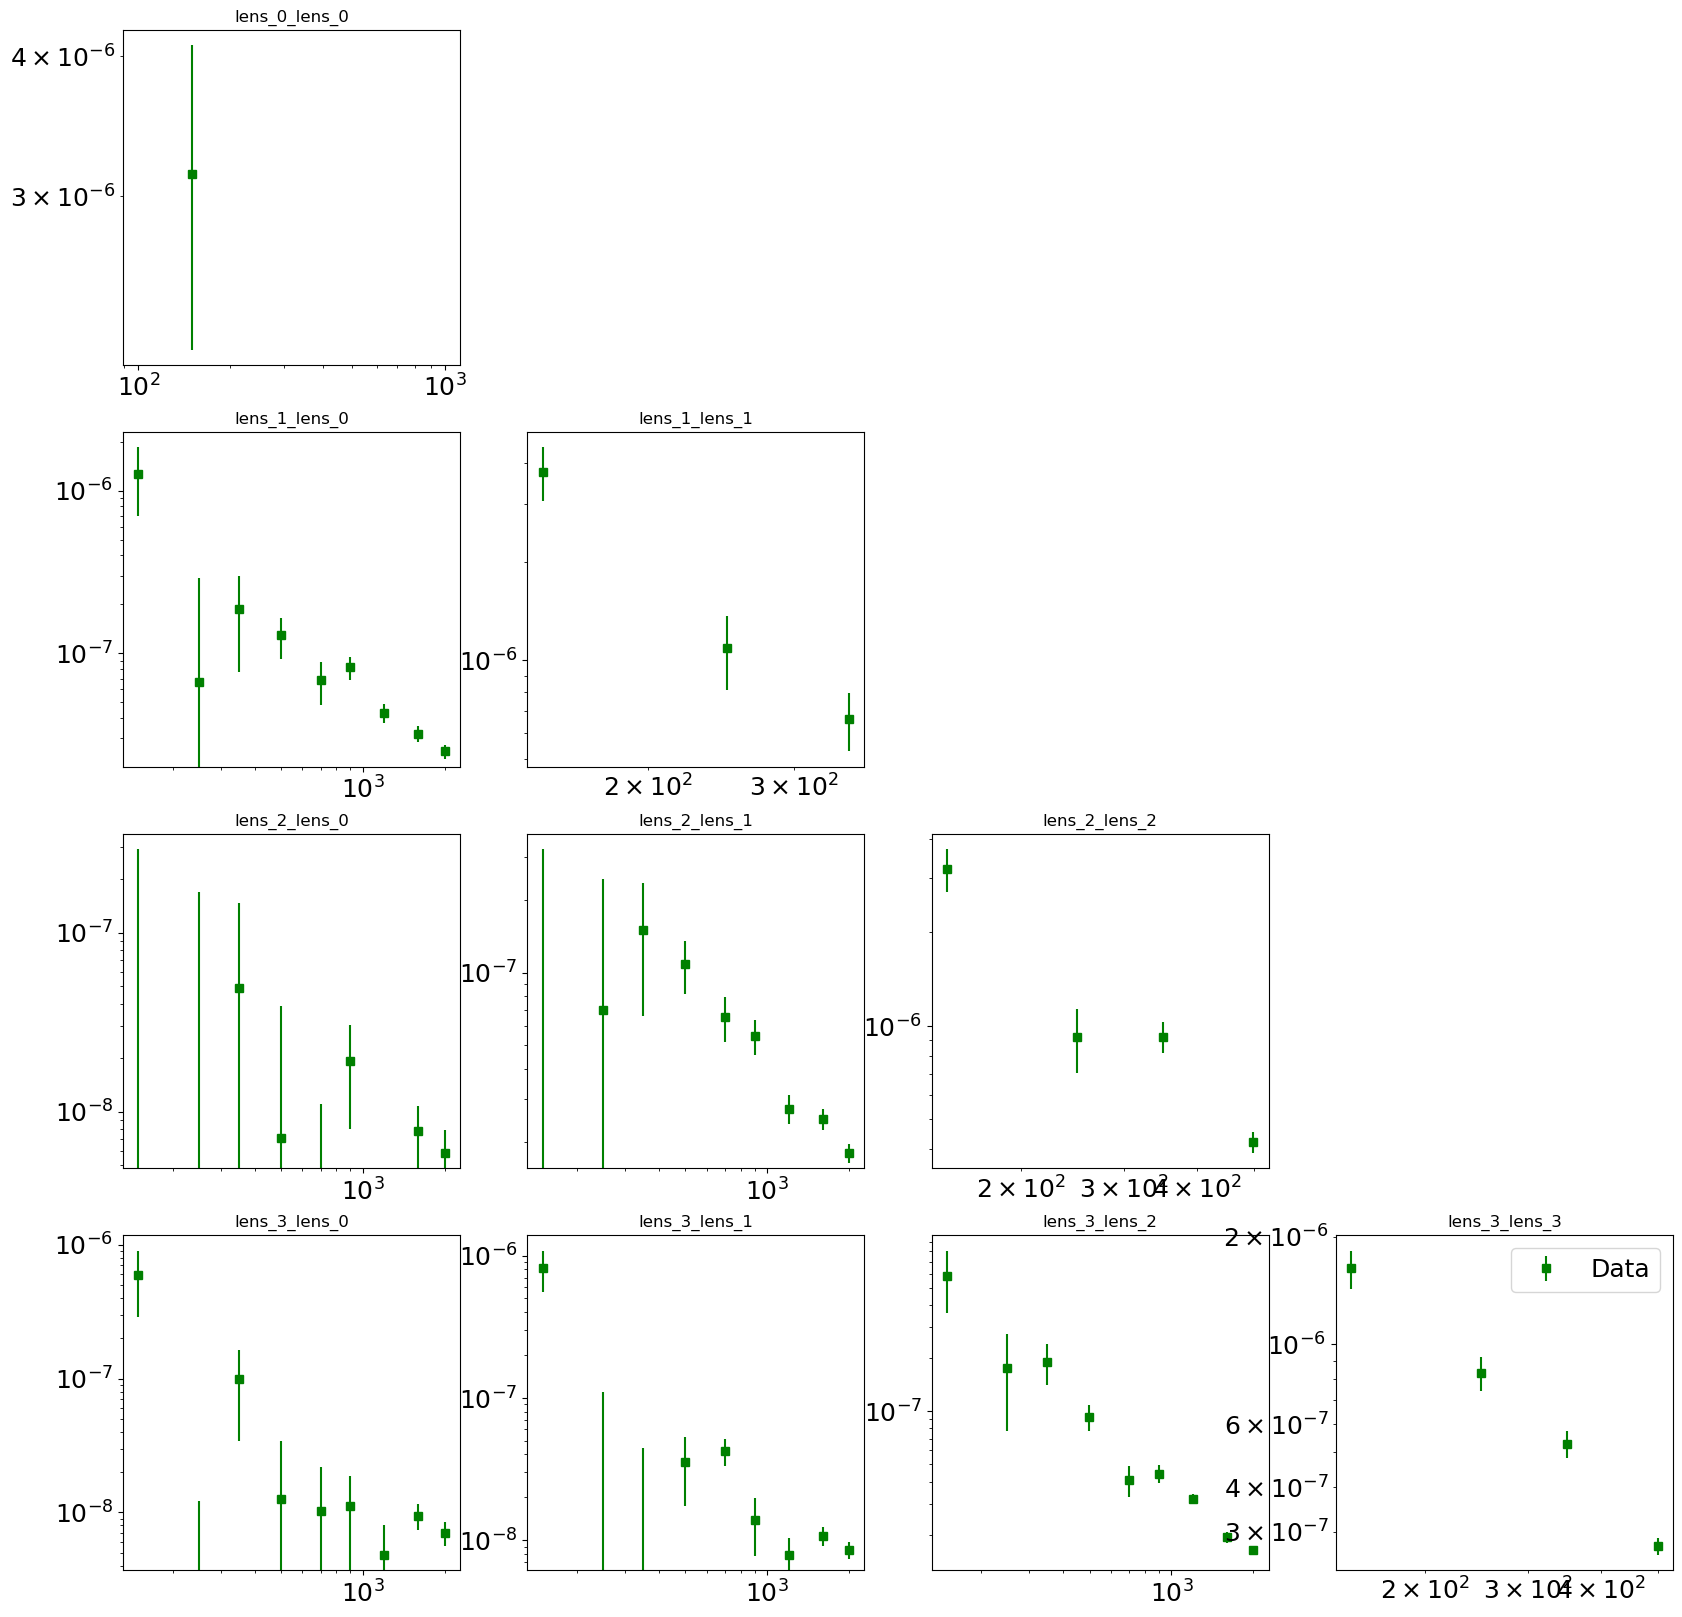

In [18]:
cle.plot_cls(cle.pairs[:10])

In [19]:
pairs_pos = [cle.pairs.index(pair) for pair in wanted_pairs]
unique_t_i = np.unique(np.transpose(wanted_pairs)[0])
unique_t_j = np.unique(np.transpose(wanted_pairs)[1])
l_t_i = len(unique_t_i)
l_t_j = len(unique_t_j)
npair = 0

figure, axis = plt.subplots(l_t_i, l_t_j, figsize=(5*l_t_i, 5*l_t_j))
for i in range(0, l_t_i):
    for j in range(0, l_t_j):
        proposed_pair = [unique_t_i[i], unique_t_j[j]]
        if proposed_pair in wanted_pairs:
            pos = pairs_pos[npair]
            ls = cle.ls[pos]
            data = cle.data[pos]
            axis[i, j].errorbar(ls, data, fmt='gs', label='Data')
            axis[i, j].set_title("{}_{}".format(proposed_pair[0],proposed_pair[1]))
            axis[i, j].set_xscale("log")
            axis[i, j].set_yscale("log")
            npair += 1
        else:
            axis[i, j].axis('off')
plt.legend()
plt.show()

NameError: name 'wanted_pairs' is not defined

In [ ]:
pairs_pos = [cle.pairs.index(pair) for pair in wanted_pairs]
unique_t_i = np.unique(np.transpose(wanted_pairs)[0])
unique_t_j = np.unique(np.transpose(wanted_pairs)[1])
l_t_i = len(unique_t_i)
l_t_j = len(unique_t_j)
npair = 0

if (unique_t_j == unique_t_i).all():
    print("Same tracers")
    figure, axis = plt.subplots(1, l_t_j, figsize=(5*l_t_i, 5*1))
    for i in range(0, l_t_i):
        proposed_pair = [unique_t_i[i], unique_t_j[i]]
        pos = pairs_pos[npair]
        ls = cle.ls[pos]
        data = cle.data[pos]
        axis[i].errorbar(ls, data, fmt='gs', label='Data')
        axis[i].set_title("{}_{}".format(proposed_pair[0],proposed_pair[1]))
        axis[i].set_xscale("log")
        axis[i].set_yscale("log")
        npair += 1
    plt.legend()
    plt.show()
else:
    print("Different tracers")
    figure, axis = plt.subplots(l_t_i, l_t_j, figsize=(5*l_t_i, 5*l_t_j))
    for i in range(0, l_t_i):
        for j in range(0, l_t_j):
            proposed_pair = [unique_t_i[i], unique_t_j[j]]
            if proposed_pair in wanted_pairs:
                pos = pairs_pos[npair]
                ls = cle.ls[pos]
                data = cle.data[pos]
                axis[i, j].errorbar(ls, data, fmt='gs', label='Data')
                axis[i, j].set_title("{}_{}".format(proposed_pair[0],proposed_pair[1]))
                axis[i, j].set_xscale("log")
                axis[i, j].set_yscale("log")
                npair += 1
            else:
                axis[i, j].axis('off')
    plt.legend()
    plt.show()

In [ ]:
class cl_plotter(object):
    def __init__(self, cle; wanted_pairs=nothing):
        self.clp = clp

In [ ]:
clp.data

In [ ]:
idx = [int(i) for i in data['indices']]

In [ ]:
cov = s.covariance.dense
cov = np.transpose(np.transpose(cov[idx])[idx])
cov